In [4]:
from pathlib import Path
import matplotlib.pyplot as plt

# **Handling single slice of DICOM data**

In [10]:
import pydicom

dicom_file = pydicom.read_file('../datasets/dicom/ID_0000_AGE_0060_CONTRAST_1_CT.dcm')
dicom_file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108821836759549281694712274169
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 430
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.1088

In [29]:
# Access attributes in dicom file

# Appraoch 1 - via hex
print(dicom_file[0x0028,0x0010])
print(type(dicom_file[0x0028,0x0010]))

print()

# Approach 2 - via attribute
print(dicom_file.Rows)
print(type(dicom_file.Rows))

(0028, 0010) Rows                                US: 512
<class 'pydicom.dataelem.DataElement'>

512
<class 'int'>


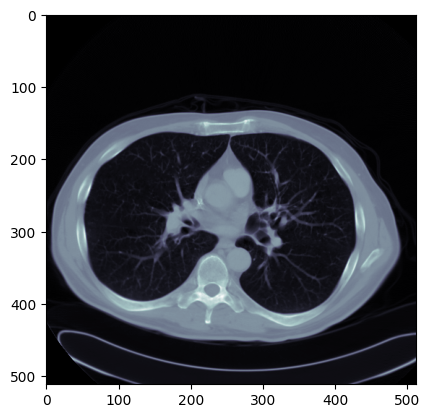

In [45]:
# Extracting image
ct = dicom_file.pixel_array
plt.imshow(ct, cmap='bone');

## **Handling multi slice of Dicom data**
- These are usually not sorted

In [49]:
# Using pathlib to obtain path of data
path_to_head_mri = Path('../datasets/dicom/SE000001')
path_to_head_mri

WindowsPath('../datasets/dicom/SE000001')

In [52]:
# Fetching files in path
all_files = list(path_to_head_mri.glob("*"))
all_files

[WindowsPath('../datasets/dicom/SE000001/MR000000'),
 WindowsPath('../datasets/dicom/SE000001/MR000001'),
 WindowsPath('../datasets/dicom/SE000001/MR000002'),
 WindowsPath('../datasets/dicom/SE000001/MR000003'),
 WindowsPath('../datasets/dicom/SE000001/MR000004'),
 WindowsPath('../datasets/dicom/SE000001/MR000005'),
 WindowsPath('../datasets/dicom/SE000001/MR000006'),
 WindowsPath('../datasets/dicom/SE000001/MR000007'),
 WindowsPath('../datasets/dicom/SE000001/MR000008'),
 WindowsPath('../datasets/dicom/SE000001/MR000009'),
 WindowsPath('../datasets/dicom/SE000001/MR000010'),
 WindowsPath('../datasets/dicom/SE000001/MR000011'),
 WindowsPath('../datasets/dicom/SE000001/MR000012'),
 WindowsPath('../datasets/dicom/SE000001/MR000013'),
 WindowsPath('../datasets/dicom/SE000001/MR000014'),
 WindowsPath('../datasets/dicom/SE000001/MR000015'),
 WindowsPath('../datasets/dicom/SE000001/MR000016'),
 WindowsPath('../datasets/dicom/SE000001/MR000017'),
 WindowsPath('../datasets/dicom/SE000001/MR000

In [57]:
# Loading mri data from path
mri_data = []
for path in all_files:
    data = pydicom.read_file(path)
    mri_data.append(data)

for s in mri_data[:5]:
    print(s.SliceLocation)

0.0
5.99999663091323
11.9999973042441
17.9999979772582
23.9999946081714


In [62]:
# Sorting data based on SliceLocation
mri_data_ordered = sorted(mri_data, key= lambda item: item.SliceLocation)
for s in mri_data_ordered:
    print(s.SliceLocation)


0.0
5.99999663091323
11.9999973042441
17.9999979772582
23.9999946081714
29.9999952815023
35.9999959546749
41.9999963629367
47.9999970362677
53.9999958207213
59.9999962290673
65.9999961939969
71.9999961590453
77.9999962275740
83.9999967682912
89.9999955528687
95.9999960937442
101.999994745866
107.999995419197
113.999995959439
119.999996566542
125.999997173645
131.999997780749
137.999998321624
143.999998928727
149.999999502083
155.999992554172


In [67]:
# Extracting image data
full_volume = []
for slice in mri_data_ordered:
    full_volume.append(slice.pixel_array)

(256, 256)

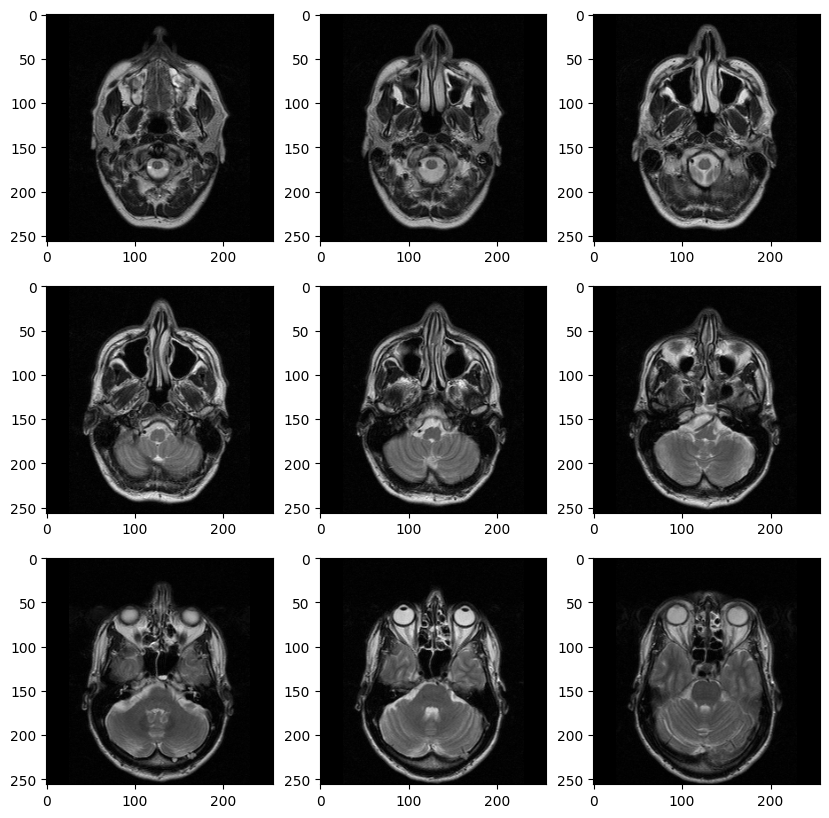

In [74]:
# Plotting image data
fig, axis = plt.subplots(3,3, figsize=(10,10))
slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(full_volume[slice_counter], cmap='gray')
        slice_counter+=1

## **Handling of multi-slice DICOM file using SITK**
- slices gets sorted

In [93]:
import SimpleITK as sitk

reader = sitk.ImageSeriesReader()

```
..\\datasets\\dicom\\SE000001/MR000000',
'..\\datasets\\dicom\\SE000001/MR000001',
```

Here,  
**SE000001** = SeriesID  
**MR000000, MR000001** = Individual Slice


In [98]:
# Fetch SeriesID
series_ids = reader.GetGDCMSeriesIDs(str(path_to_head_mri))
print(f"# of series: {len(series_ids)}")
series_ids

# of series: 1


('1.3.46.670589.11.0.0.11.4.2.0.12098.5.4500.2015011413262801702',)

In [103]:
# Fetch slices of selected Series ID
series_file_names = reader.GetGDCMSeriesFileNames(str(path_to_head_mri),series_ids[0])
print(f"Number of slices: {len(series_file_names)}")
series_file_names[:3]

Number of slices: 27


('..\\datasets\\dicom\\SE000001/MR000000',
 '..\\datasets\\dicom\\SE000001/MR000001',
 '..\\datasets\\dicom\\SE000001/MR000002')

In [104]:
# Construct 3D image from slices extracted from selected series
reader.SetFileNames(series_file_names)

In [110]:
# Initiate Reconstruction into 3D image
image_data = reader.Execute()
type(image_data)

SimpleITK.SimpleITK.Image

In [113]:
# Obtains a view (not a copy) and translate into numpy array
head_mri = sitk.GetArrayViewFromImage(image_data)
print(type(head_mri))
head_mri.shape

<class 'numpy.ndarray'>


(27, 256, 256)

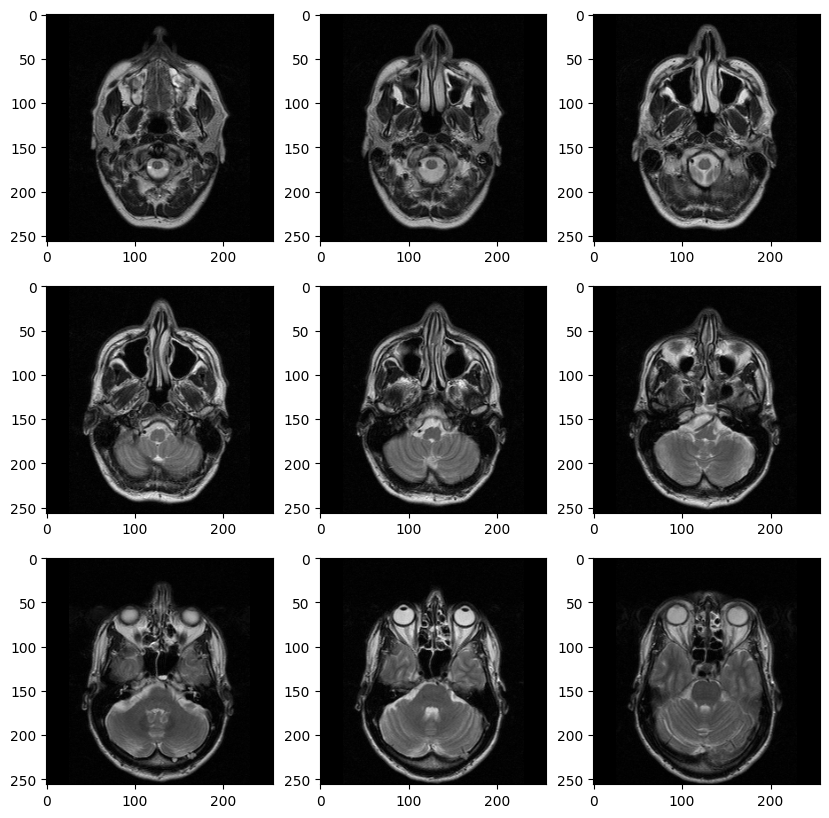

In [91]:
# Plotting image data
fig, axis = plt.subplots(3,3, figsize=(10,10))
slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(head_mri[slice_counter], cmap='gray')
        slice_counter+=1